In [1]:
import numpy as np
import jax.numpy as jnp
import scipy.sparse as ss
import matplotlib.pyplot as plt

from jax import jit, vmap

from src.fem import Graph
from const import *
from util import *

In [2]:
@jit
def f(x):
    return x[0]**2 + x[1]**2 + 1
@jit
def g(x):
    return x[0] + x[1]

A = ss.coo_array(
    np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [-1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
              [0, 0, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
              [0, 0, 0, -1, 0, -1, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1]], 
             dtype=int)) # cube

featA = np.array([[0, 0, 0],
                 [1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1],
                 [1, 1, 0],
                 [1, 0, 1],
                 [0, 1, 1],
                 [1, 1, 1]])

B = ss.coo_array(
    np.array([[1, 1, 1, 1],
              [-1, 0, 0, 0],
              [0, -1, 0, 0],
              [0, 0, -1, 0],
              [0, 0, 0, -1]], 
             dtype=int)) # cross

featB = np.array([[0, 0, 0],
                  [-1, 0, 0],
                  [0, -1, 0],
                  [1, 0, 0],
                  [0, 1, 0]])

C = ss.coo_array(
    np.array([[1, 0, 0, -1],
              [-1, 1, 0, 0],
              [0, -1, 1, 0],
              [0, 0, -1, 1]], 
             dtype=int)) # square

featC = np.array([[0, 1, 0],
                  [-1, 0, 0],
                  [0, -1, 0],
                  [1, 0, 0]])

D = ss.coo_array(
    np.array([[1, 1],
              [-1, 0],
              [0, -1]],
             dtype=int)) # ortho

featD = np.array([[0, 0, 0],
                  [-1, 0, 0],
                  [0, -1, 0]])

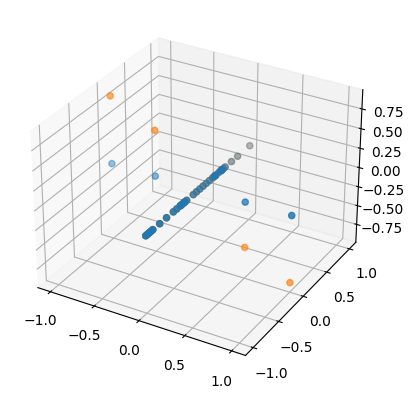

In [9]:
T = Graph(B, featB, f)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(50):
    T.refine(T.wrap_random())
    if i%2:
        T.coarsen(T.wrap_random())
T.calculate_eigen(1)

ax.scatter(T.coord[:, 0][:T.vcnt],
           T.coord[:, 1][:T.vcnt],
           T.coord[:, 2][:T.vcnt])

ax.scatter(T.coord[:, 0][:T.vcnt],
           T.coord[:, 1][:T.vcnt],
           T.u)

In [11]:
T.u

array([ 2.18647556e-12+0.j,  8.64985064e-01+0.j, -3.69582616e-11+0.j,
       -8.64985064e-01+0.j, -5.57881635e-11+0.j, -1.93158743e-11+0.j,
       -3.70754893e-11+0.j, -1.85444766e-11+0.j, -2.34792124e-11+0.j,
       -2.82288853e-11+0.j, -2.52707554e-11+0.j, -1.26106257e-11+0.j,
       -3.27735833e-11+0.j, -3.67442327e-11+0.j, -2.10326651e-11+0.j,
       -3.49637202e-11+0.j, -3.05286013e-11+0.j, -2.22608415e-11+0.j,
       -3.24969157e-11+0.j, -3.38307256e-11+0.j,  5.84923732e-01+0.j,
       -3.61384553e-11+0.j, -3.16584752e-11+0.j, -1.60337706e-11+0.j,
       -8.29877506e-12+0.j, -1.43413295e-11+0.j, -1.76998696e-11+0.j,
       -3.07567301e-12+0.j, -1.34694497e-11+0.j, -3.64862934e-11+0.j,
       -2.28736066e-11+0.j, -5.39551686e-12+0.j, -1.62889943e-12+0.j,
       -2.24049357e-11+0.j, -3.22189158e-11+0.j, -3.01712107e-11+0.j,
       -1.51989722e-11+0.j, -5.06381017e-11+0.j, -5.84923731e-01+0.j,
       -3.19373633e-11+0.j, -3.69050276e-11+0.j, -1.85168434e-11+0.j,
       -4.47026798e-